In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
archive_folder_path = '/content/drive/My Drive/archive (2)'

In [ ]:
#importing
import pandas as pd
import numpy as np
import re
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Make sure plots render cleanly
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
!pip install imblearn




In [ ]:
import pandas as pd
import numpy as np
import re
import json
from sklearn.preprocessing import LabelEncoder

# Load Global Dataset
file_path = f"{archive_folder_path}/Global_Dataset.xlsx"
df = pd.read_excel(file_path)

# Remove invalid CWE entries
invalid_cwe = ['NVD-CWE-Other', 'NVD-CWE-noinfo', 'Unknown', '', None]
df_clean = df[~df['CWE-ID'].isin(invalid_cwe)]

# Convert CVSS fields to numeric
df_clean['CVSS-V3'] = pd.to_numeric(df_clean['CVSS-V3'], errors='coerce')
df_clean['CVSS-V2'] = pd.to_numeric(df_clean['CVSS-V2'], errors='coerce')

# Create unified CVSS score
df_clean['CVSS'] = df_clean['CVSS-V3'].fillna(df_clean['CVSS-V2'])

# Drop rows still missing CVSS
df_clean = df_clean.dropna(subset=['CVSS'])

# Extract year from CVE-ID
df_clean['YEAR'] = df_clean['CVE-ID'].apply(lambda x: int(x.split("-")[1]) if "-" in x else np.nan)

# Retain only needed columns
df_clean = df_clean[['CVE-ID', 'YEAR', 'CVSS', 'SEVERITY', 'DESCRIPTION', 'CWE-ID']]


<ipython-input-5-df3f959e637d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CVSS-V3'] = pd.to_numeric(df_clean['CVSS-V3'], errors='coerce')
<ipython-input-5-df3f959e637d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CVSS-V2'] = pd.to_numeric(df_clean['CVSS-V2'], errors='coerce')
<ipython-input-5-df3f959e637d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
# Load synonym mapping JSON
with open(f"{archive_folder_path}/synonym_mapping.json", "r", encoding="utf-8") as f:
    synonym_map = json.load(f)

# Build flat word lookup dictionary
word_lookup = {}
for base, variants in synonym_map.items():
    for variant in variants:
        word_lookup[variant.lower()] = base.lower()


In [ ]:
# Define efficient tokenizer with word replacement
def fast_tokenize_and_replace(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = text.split()
    replaced_tokens = [word_lookup.get(token, token) for token in tokens]
    return " ".join(replaced_tokens)

# Apply to a sample for testing (e.g., 50000 rows)
sample_df = df_clean.sample(n=50000, random_state=42).copy()
sample_df['DESCRIPTION_CLEAN'] = sample_df['DESCRIPTION'].apply(fast_tokenize_and_replace)


In [ ]:
# Encode SEVERITY into numerical labels
severity_map = {'CRITICAL': 2, 'HIGH': 2, 'MEDIUM': 1, 'LOW': 0}
sample_df['SEVERITY_ENC'] = sample_df['SEVERITY'].map(severity_map)

# Encode CWE-ID into categorical integers
cwe_encoder = LabelEncoder()
cwe_encoder.fit(df_clean['CWE-ID'])  # use full set for fitting
sample_df['CWE_ENC'] = cwe_encoder.transform(sample_df['CWE-ID'])


In [ ]:
# Save to CSV for modeling
sample_df.to_csv("model_ready_dataset_50k.csv", index=False)


In [ ]:
sample_df = pd.read_csv("model_ready_dataset_50k.csv")

**1️⃣ SEVERITY Class Distribution**

<ipython-input-31-30922330f214>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sample_df, x='SEVERITY_ENC', palette='viridis')


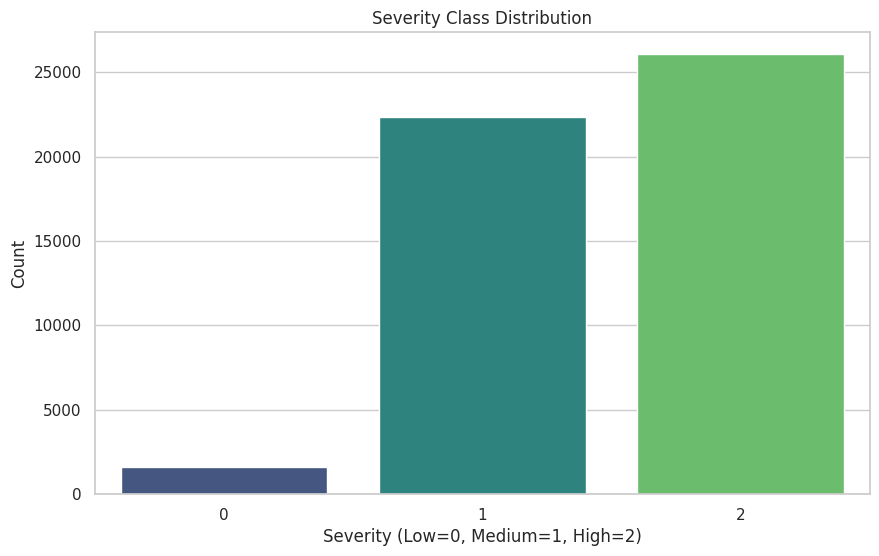

In [ ]:
sns.countplot(data=sample_df, x='SEVERITY_ENC', palette='viridis')
plt.title("Severity Class Distribution")
plt.xlabel("Severity (Low=0, Medium=1, High=2)")
plt.ylabel("Count")
plt.show()


**Top 15 Most Frequent CWE Categories**

<ipython-input-32-ec91a0e7fca9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cwes.values, y=top_cwes.index, palette='magma')


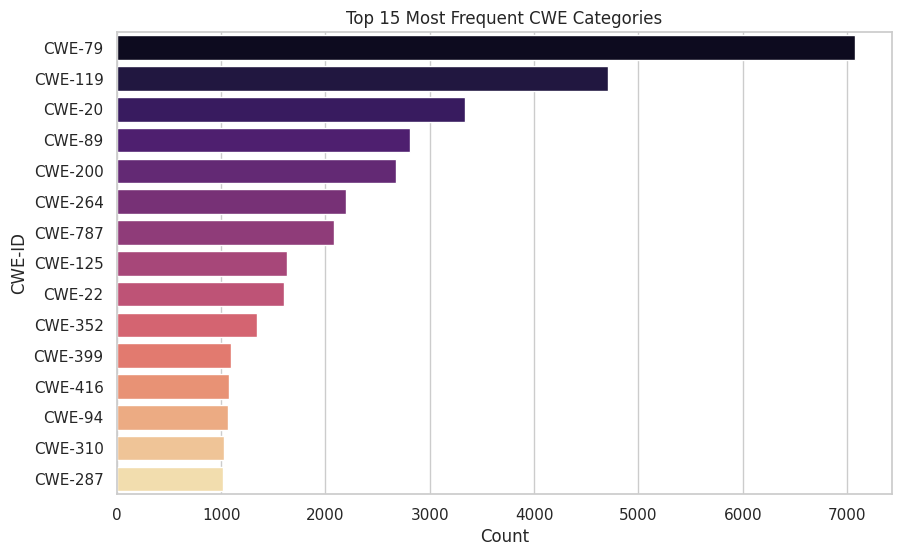

In [ ]:
top_cwes = sample_df['CWE-ID'].value_counts().nlargest(15)
sns.barplot(x=top_cwes.values, y=top_cwes.index, palette='magma')
plt.title("Top 15 Most Frequent CWE Categories")
plt.xlabel("Count")
plt.ylabel("CWE-ID")
plt.show()


**CVSS Score Distribution**

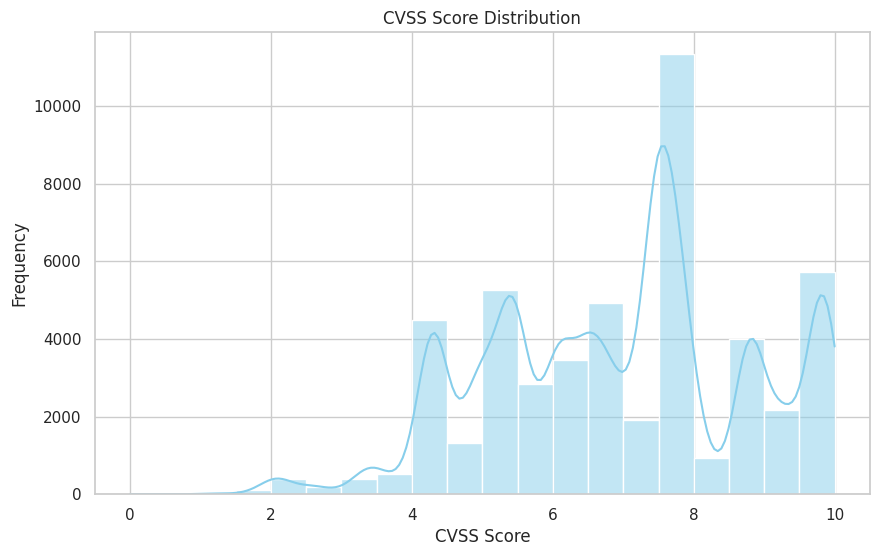

In [ ]:
sns.histplot(sample_df['CVSS'], bins=20, kde=True, color='skyblue')
plt.title("CVSS Score Distribution")
plt.xlabel("CVSS Score")
plt.ylabel("Frequency")
plt.show()


**Text Length Distribution**

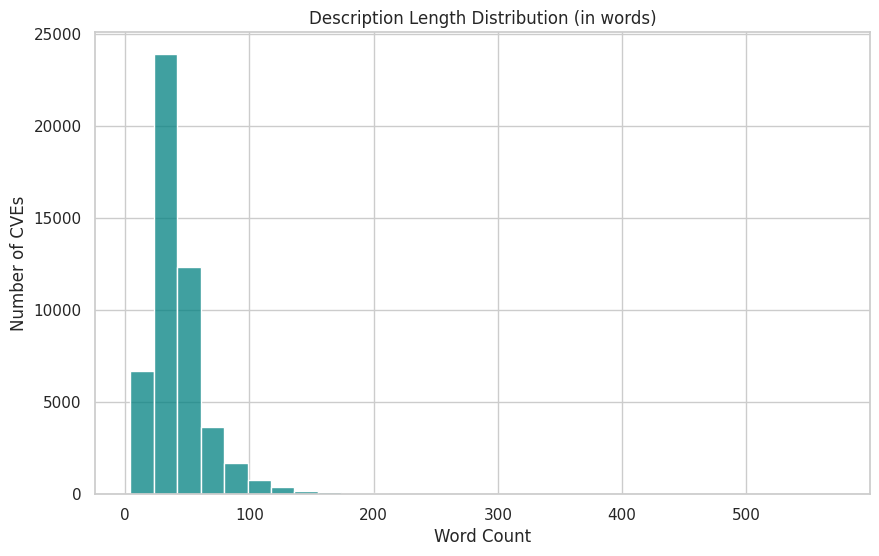

In [ ]:
sample_df['DESC_LEN'] = sample_df['DESCRIPTION_CLEAN'].apply(lambda x: len(x.split()))
sns.histplot(sample_df['DESC_LEN'], bins=30, color='teal')
plt.title("Description Length Distribution (in words)")
plt.xlabel("Word Count")
plt.ylabel("Number of CVEs")
plt.show()


**Correlation Heatmap**

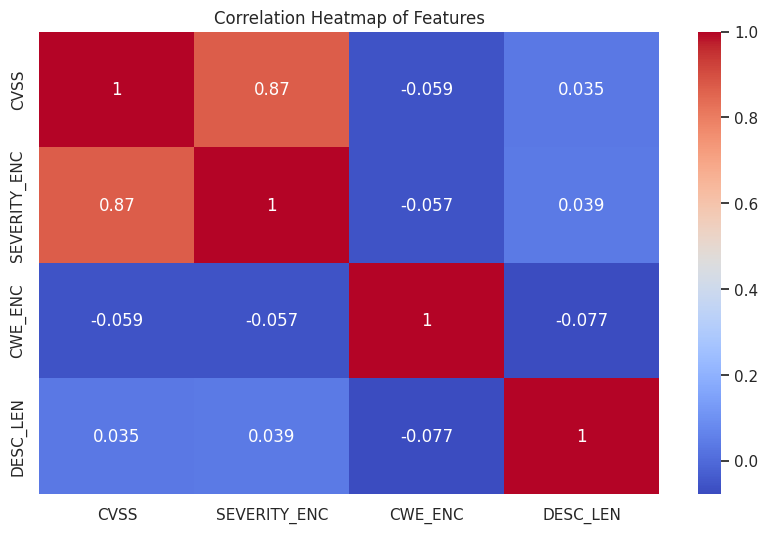

In [ ]:
correlation = sample_df[['CVSS', 'SEVERITY_ENC', 'CWE_ENC', 'DESC_LEN']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()


**Number of CVEs Reported per Year**

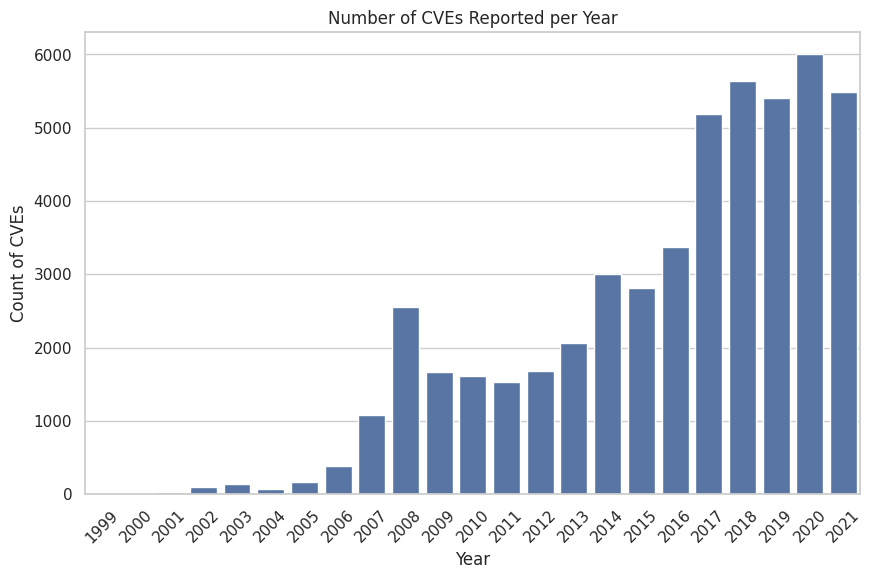

In [ ]:
sns.countplot(data=sample_df, x='YEAR', order=sorted(sample_df['YEAR'].unique()))
plt.title("Number of CVEs Reported per Year")
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Count of CVEs")
plt.show()


**Average CVSS Score by Year**

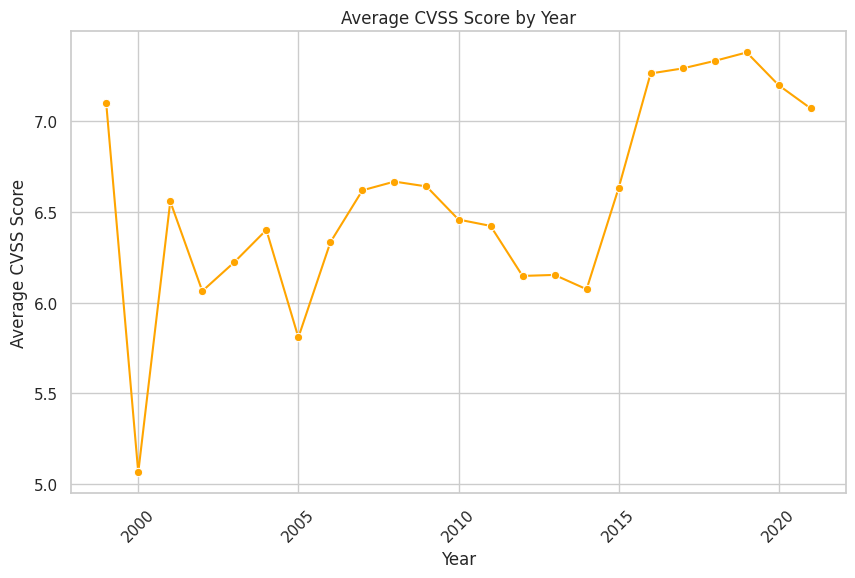

In [ ]:
avg_cvss_year = sample_df.groupby('YEAR')['CVSS'].mean().reset_index()

sns.lineplot(data=avg_cvss_year, x='YEAR', y='CVSS', marker='o', color='orange')
plt.title("Average CVSS Score by Year")
plt.xlabel("Year")
plt.ylabel("Average CVSS Score")
plt.xticks(rotation=45)
plt.show()


**Severity Distribution Over Time (Stacked)**

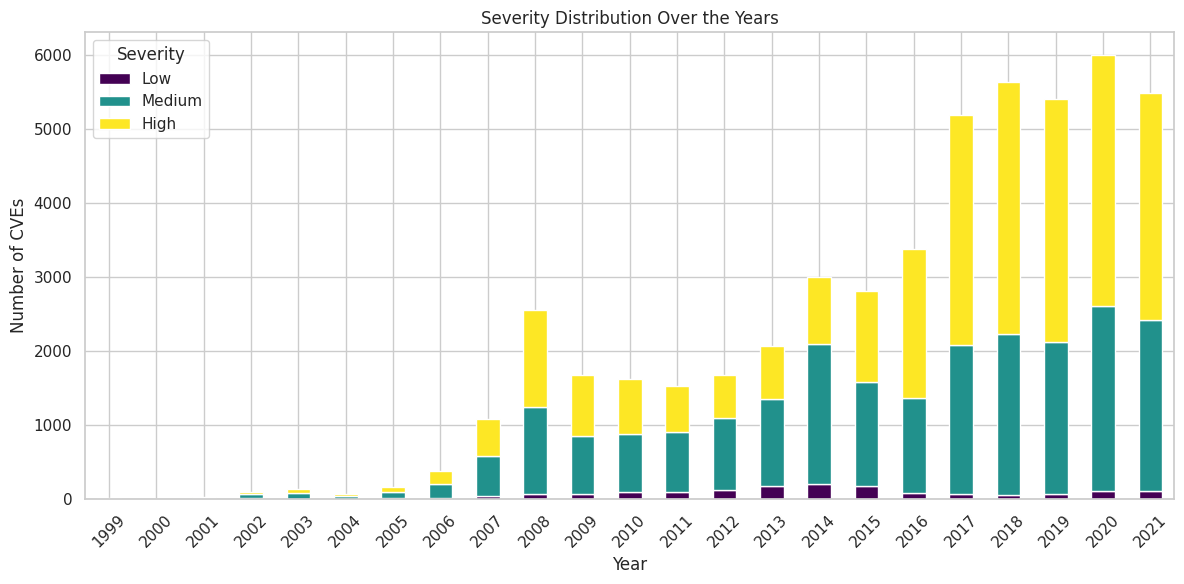

In [ ]:
# Create pivot table
severity_year_pivot = sample_df.pivot_table(index='YEAR', columns='SEVERITY_ENC', values='CVE-ID', aggfunc='count').fillna(0)

# Plot stacked bar chart
severity_year_pivot.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title("Severity Distribution Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.legend(title="Severity", labels=["Low", "Medium", "High"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Predictive Modeling Pipeline**

**Import & Prepare the Data**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the 50K dataset
df = pd.read_csv("model_ready_dataset_50k.csv")

# Features and target
X_base = df[['DESCRIPTION_CLEAN', 'CWE_ENC', 'CVSS']]
y = df['SEVERITY_ENC']


**Text Vectorization (TF-IDF)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Vectorize cleaned descriptions
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(X_base['DESCRIPTION_CLEAN'])

# Combine text + numerical features
import numpy as np
X_combined = hstack([X_text,
                     np.array(X_base[['CWE_ENC', 'CVSS']])])


**Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y)


**Train Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)


Random Forest (Original) Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       321
           1       0.99      1.00      0.99      4468
           2       1.00      1.00      1.00      5211

    accuracy                           0.99     10000
   macro avg       1.00      0.94      0.96     10000
weighted avg       0.99      0.99      0.99     10000



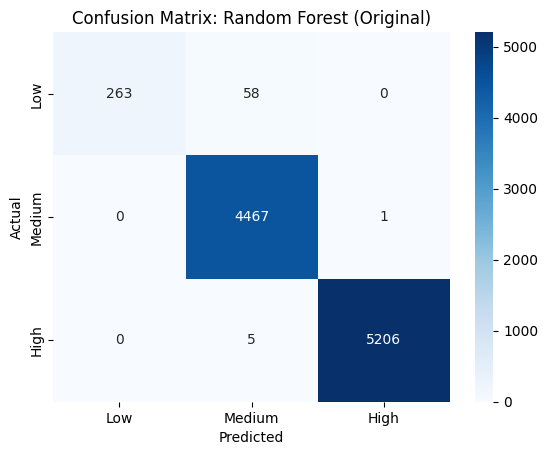


Random Forest (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       321
           1       0.99      1.00      0.99      4468
           2       1.00      1.00      1.00      5211

    accuracy                           0.99     10000
   macro avg       0.99      0.96      0.97     10000
weighted avg       0.99      0.99      0.99     10000



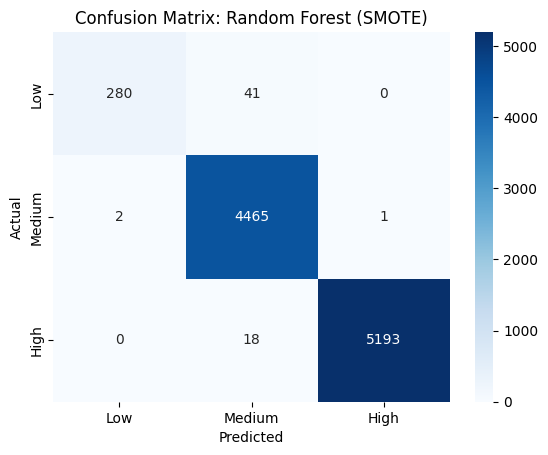


Random Forest (LDA) Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       321
           1       0.96      0.96      0.96      4468
           2       0.97      0.97      0.97      5211

    accuracy                           0.96     10000
   macro avg       0.96      0.93      0.94     10000
weighted avg       0.96      0.96      0.96     10000



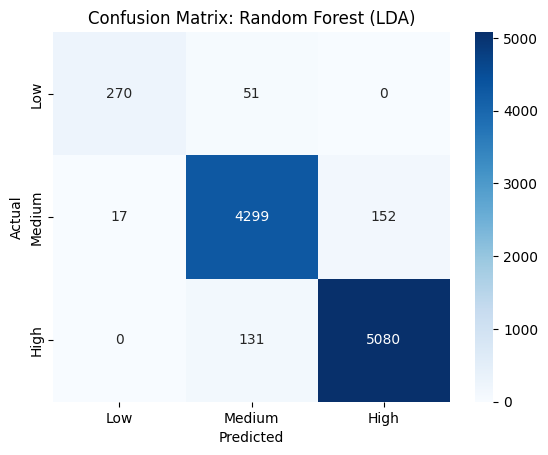

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# ORIGINAL
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train, y_train)
y_pred_original = rf_original.predict(X_test)

# SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_resampled, y_resampled)
y_pred_smote = rf_smote.predict(X_test)

# LDA
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_dense, y_train)
X_test_lda = lda.transform(X_test_dense)
rf_lda = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lda.fit(X_train_lda, y_train)
y_pred_lda = rf_lda.predict(X_test_lda)

# EVALUATION
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Random Forest (Original)", y_test, y_pred_original)
evaluate_model("Random Forest (SMOTE)", y_test, y_pred_smote)
evaluate_model("Random Forest (LDA)", y_test, y_pred_lda)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Logistic Regression (Original) Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       321
           1       1.00      1.00      1.00      4468
           2       1.00      1.00      1.00      5211

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



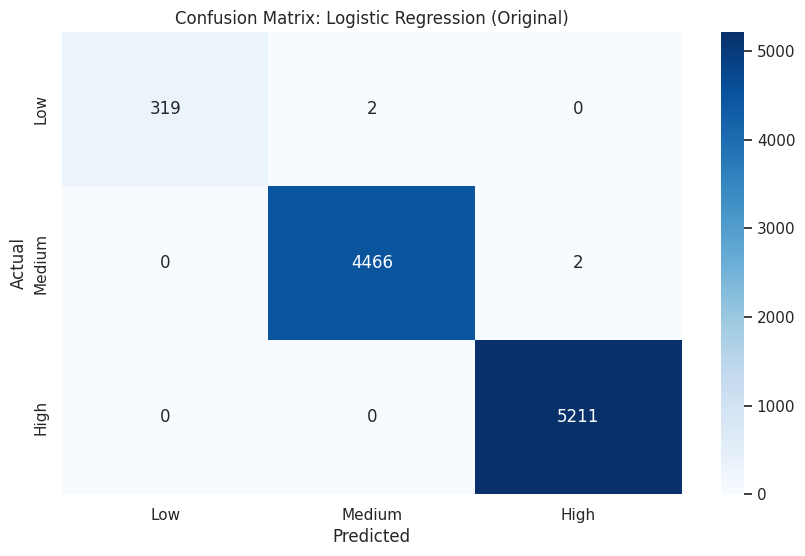


Logistic Regression (Tuned - Original) Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       321
           1       1.00      1.00      1.00      4468
           2       1.00      1.00      1.00      5211

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



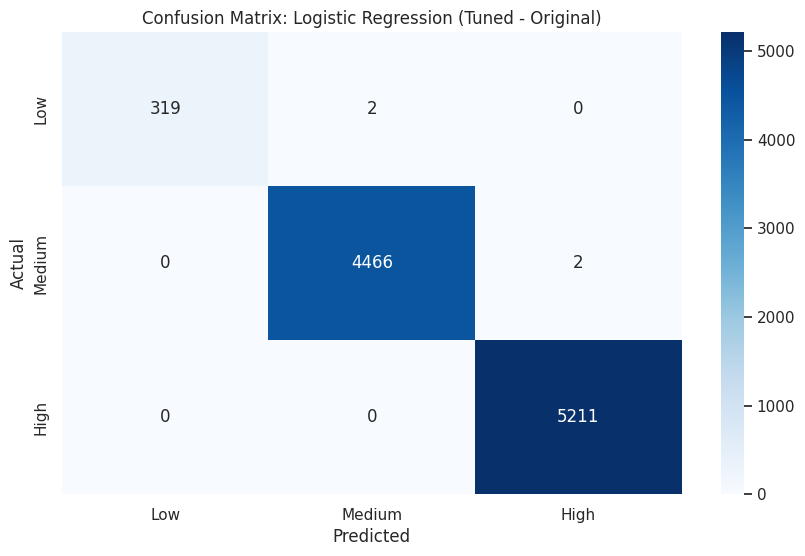


Logistic Regression (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00      4468
           2       1.00      1.00      1.00      5211

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



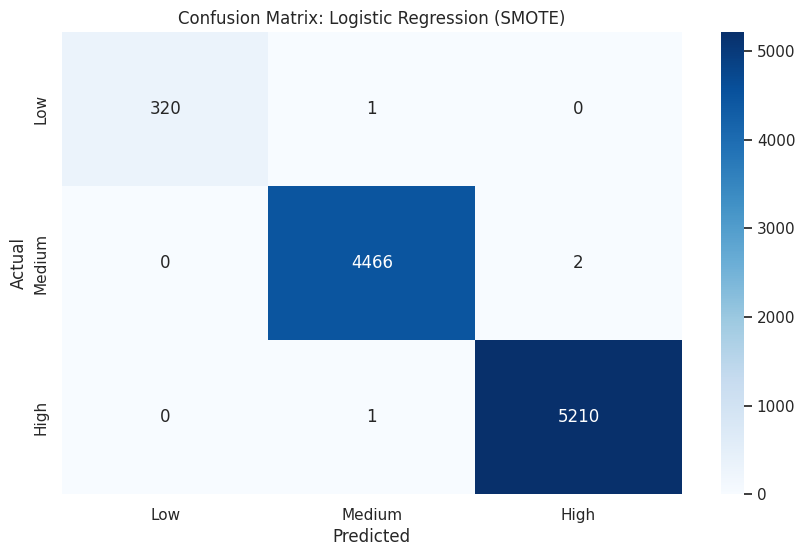


Logistic Regression (LDA) Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       321
           1       0.96      0.96      0.96      4468
           2       0.97      0.97      0.97      5211

    accuracy                           0.96     10000
   macro avg       0.95      0.92      0.94     10000
weighted avg       0.96      0.96      0.96     10000



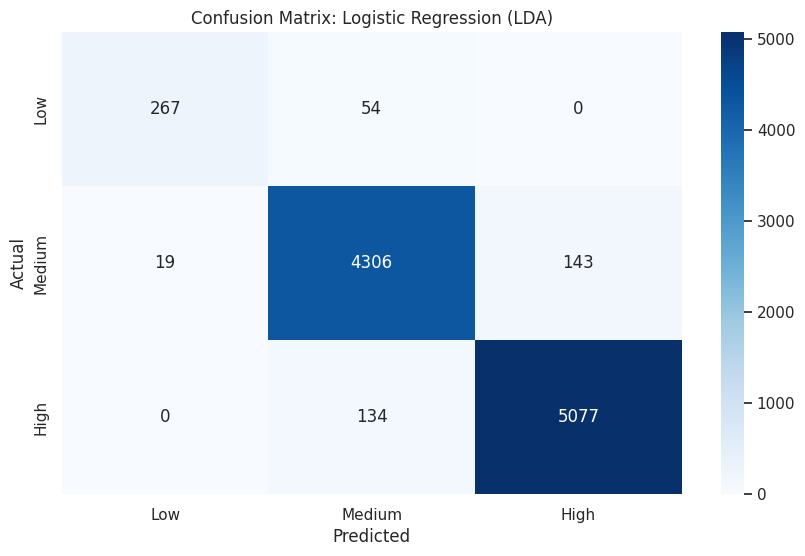

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


# 1️⃣ ORIGINAL
lr_original = LogisticRegression(max_iter=1000, random_state=42)
lr_original.fit(X_train, y_train)
y_pred_original = lr_original.predict(X_test)

# Tuning hyperparameters on original features
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted'
)
grid_lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr_tuned = grid_lr.predict(X_test)

# 2️⃣ SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_resampled, y_resampled)
y_pred_smote = lr_smote.predict(X_test)

# 3️⃣ LDA
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_dense, y_train)
X_test_lda = lda.transform(X_test_dense)
lr_lda = LogisticRegression(max_iter=1000, random_state=42)
lr_lda.fit(X_train_lda, y_train)
y_pred_lda = lr_lda.predict(X_test_lda)

# 🔍 EVALUATION FUNCTION
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Logistic Regression (Original)", y_test, y_pred_original)
evaluate_model("Logistic Regression (Tuned - Original)", y_test, y_pred_lr_tuned)
evaluate_model("Logistic Regression (SMOTE)", y_test, y_pred_smote)
evaluate_model("Logistic Regression (LDA)", y_test, y_pred_lda)




Naive Bayes (Original) Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.08      0.15       321
           1       0.60      0.61      0.60      4468
           2       0.66      0.69      0.68      5211

    accuracy                           0.64     10000
   macro avg       0.74      0.46      0.48     10000
weighted avg       0.64      0.64      0.63     10000



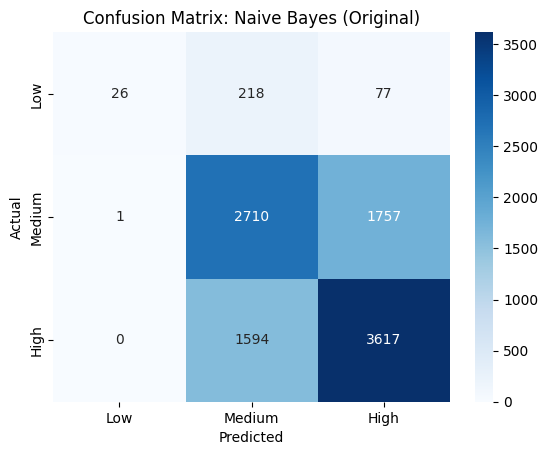


Naive Bayes (Original Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.14      0.24       321
           1       0.60      0.61      0.61      4468
           2       0.66      0.70      0.68      5211

    accuracy                           0.64     10000
   macro avg       0.73      0.48      0.51     10000
weighted avg       0.65      0.64      0.63     10000



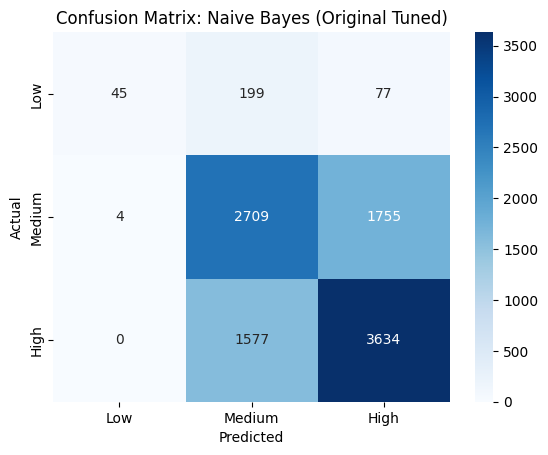


Naive Bayes (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.25      0.68      0.37       321
           1       0.56      0.49      0.53      4468
           2       0.67      0.68      0.67      5211

    accuracy                           0.59     10000
   macro avg       0.50      0.61      0.52     10000
weighted avg       0.61      0.59      0.60     10000



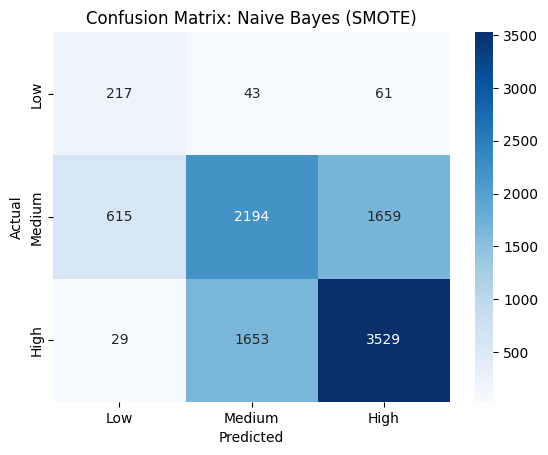


Naive Bayes (SMOT Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36       321
           1       0.57      0.49      0.53      4468
           2       0.67      0.68      0.68      5211

    accuracy                           0.60     10000
   macro avg       0.50      0.61      0.52     10000
weighted avg       0.61      0.60      0.60     10000



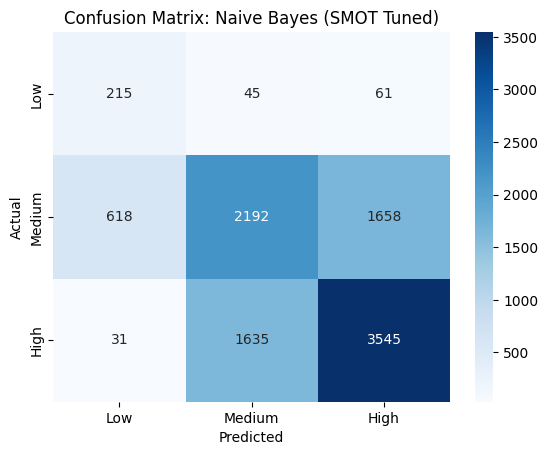


Naive Bayes (LDA + GaussianNB) Evaluation:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       321
           1       0.96      0.95      0.95      4468
           2       0.96      0.98      0.97      5211

    accuracy                           0.96     10000
   macro avg       0.93      0.90      0.91     10000
weighted avg       0.96      0.96      0.96     10000



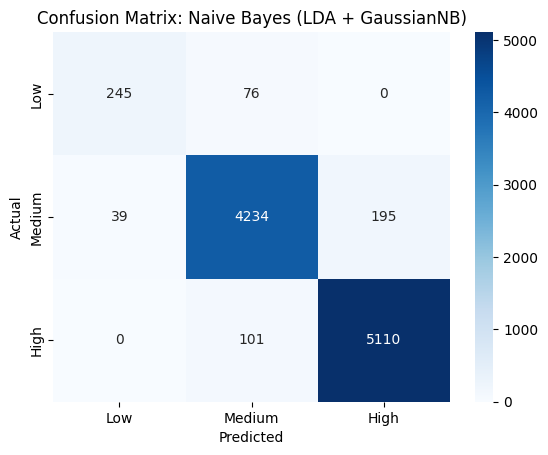

In [ ]:
# Required installations if not already installed
# !pip install imblearn

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# Load data
df = pd.read_csv("model_ready_dataset_50k.csv")

# TF-IDF + combine with numeric features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['DESCRIPTION_CLEAN'])
X_numeric = df[['CWE_ENC', 'CVSS']].values
X = hstack([X_text, X_numeric])
y = df['SEVERITY_ENC']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 1️⃣ Naive Bayes - Original
nb_original = MultinomialNB()
nb_original.fit(X_train, y_train)
y_pred_original = nb_original.predict(X_test)
evaluate_model("Naive Bayes (Original)", y_test, y_pred_original)

# Tuned the original
# Define parameter grid for alpha
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

# Grid SearchCV with 3-fold cross-validation
grid_nb_original = GridSearchCV(
    MultinomialNB(),
    param_grid=param_grid_nb,
    cv=3,
    scoring='f1_weighted'
)

# Fit and predict
grid_nb_original.fit(X_train, y_train)
nb_best_original = grid_nb_original.best_estimator_
y_pred_nb_original_tuned = nb_best_original.predict(X_test)

# Evaluate
evaluate_model("Naive Bayes (Original Tuned)", y_test, y_pred_nb_original_tuned)

# 2️⃣ Naive Bayes - SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
nb_smote = MultinomialNB()
nb_smote.fit(X_resampled, y_resampled)
y_pred_smote = nb_smote.predict(X_test)
evaluate_model("Naive Bayes (SMOTE)", y_test, y_pred_smote)

#Tuned with the SMOT
# Define parameter grid for alpha
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

# Grid SearchCV with 3-fold cross-validation
grid_nb_original = GridSearchCV(
    MultinomialNB(),
    param_grid=param_grid_nb,
    cv=3,
    scoring='f1_weighted'
)

# Fit and predict
grid_nb_original.fit(X_resampled, y_resampled)
y_pred_nb_smote_tuned = grid_nb_original.predict(X_test)

# Evaluate
evaluate_model("Naive Bayes (SMOT Tuned)", y_test, y_pred_nb_smote_tuned)

# 3️⃣ Naive Bayes - LDA + Tuning
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_dense, y_train)
X_test_lda = lda.transform(X_test_dense)

nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)
y_pred_lda = nb_lda.predict(X_test_lda)

evaluate_model("Naive Bayes (LDA + GaussianNB)", y_test, y_pred_lda)



SVM (Original) Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       321
           1       0.98      0.99      0.98      4468
           2       0.99      1.00      1.00      5211

    accuracy                           0.99     10000
   macro avg       0.99      0.90      0.94     10000
weighted avg       0.99      0.99      0.99     10000



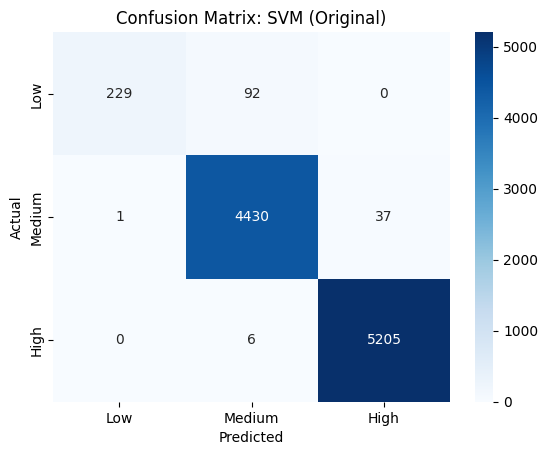


SVM (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       321
           1       1.00      0.96      0.98      4468
           2       0.97      1.00      0.99      5211

    accuracy                           0.98     10000
   macro avg       0.97      0.99      0.98     10000
weighted avg       0.98      0.98      0.98     10000



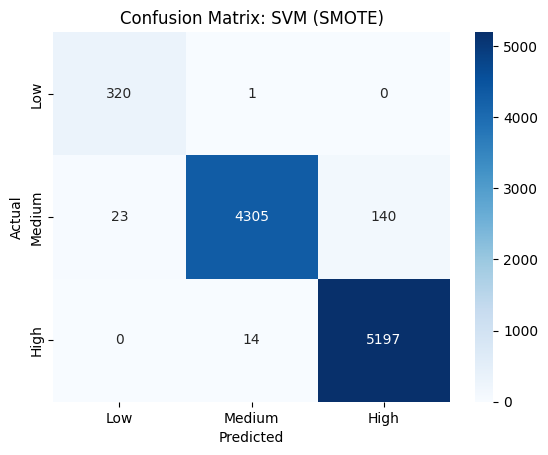


SVM (LDA Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.51      0.67       321
           1       0.94      0.96      0.95      4468
           2       0.96      0.98      0.97      5211

    accuracy                           0.96     10000
   macro avg       0.96      0.82      0.86     10000
weighted avg       0.96      0.96      0.95     10000



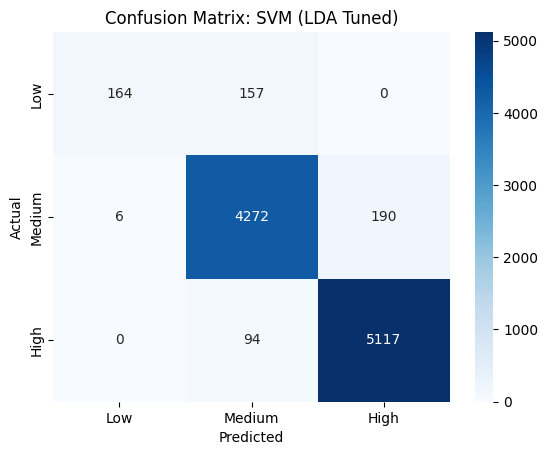

In [ ]:
# !pip install imblearn   ← Only if not installed yet

import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# Load dataset
df = pd.read_csv("model_ready_dataset_50k.csv")
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['DESCRIPTION_CLEAN'])
X_numeric = df[['CWE_ENC', 'CVSS']].values
X = hstack([X_text, X_numeric])
y = df['SEVERITY_ENC']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Eval function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 1️⃣ Original
svm_original = LinearSVC(max_iter=10000, random_state=42)
svm_original.fit(X_train, y_train)
y_pred_original = svm_original.predict(X_test)
evaluate_model("SVM (Original)", y_test, y_pred_original)

# 2️⃣ SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
svm_smote = LinearSVC(max_iter=10000, random_state=42)
svm_smote.fit(X_resampled, y_resampled)
y_pred_smote = svm_smote.predict(X_test)
evaluate_model("SVM (SMOTE)", y_test, y_pred_smote)

# 3️⃣ LDA + Tuning
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_dense, y_train)
X_test_lda = lda.transform(X_test_dense)

param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_svm = GridSearchCV(LinearSVC(max_iter=10000, random_state=42), param_grid, cv=3, scoring='f1_weighted')
grid_svm.fit(X_train_lda, y_train)
svm_lda_best = grid_svm.best_estimator_
y_pred_lda = svm_lda_best.predict(X_test_lda)
evaluate_model("SVM (LDA Tuned)", y_test, y_pred_lda)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import pandas as pd

# Load your dataset
df = pd.read_csv("model_ready_dataset_50k.csv")
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['DESCRIPTION_CLEAN'])
X_numeric = df[['CWE_ENC', 'CVSS']].values
X_combined = hstack([X_text, X_numeric])
y = df['SEVERITY_ENC']

# Prepare LDA
X_combined_dense = X_combined.toarray()
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_combined_dense, y)

# Best models for comparison
models = {
    "Random Forest (Original)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression (LDA Tuned)": LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42),
    "Naive Bayes (LDA + GaussianNB)": GaussianNB(),
    "SVM (LDA Tuned)": LinearSVC(C=1.0, max_iter=10000, random_state=42)
}

X_sets = {
    "Random Forest (Original)": X_combined,
    "Logistic Regression (LDA Tuned)": X_lda,
    "Naive Bayes (LDA + GaussianNB)": X_lda,
    "SVM (LDA Tuned)": X_lda
}

# Run cross-validation
cv_results = {}
for name, model in models.items():
    X_input = X_sets[name]
    scores = cross_val_score(model, X_input, y, cv=5, scoring='f1_weighted')
    cv_results[name] = {
        'F1 Mean': scores.mean(),
        'F1 Std': scores.std()
    }

# Show results
cv_df = pd.DataFrame(cv_results).T.reset_index()
cv_df.columns = ['Model', 'F1 Score (Mean)', 'F1 Score (Std)']
print(cv_df)


                             Model  F1 Score (Mean)  F1 Score (Std)
0         Random Forest (Original)         0.992829        0.001252
1  Logistic Regression (LDA Tuned)         0.958992        0.002465
2   Naive Bayes (LDA + GaussianNB)         0.967827        0.001976
3                  SVM (LDA Tuned)         0.963691        0.002310
